In [2]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [107]:
# import data 
data = pd.read_csv('Data/ImprovedAirbnbCleaned.csv')
data.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
Bronx                               int64
Brooklyn                            int64
Manhattan                           int64
Queens                              int64
Staten Island                       int64
days_since_last_review            float64
Entire home/apt                     int64
Private room                      

In [108]:
# drop columns that are not needed
data = data.drop(['id', 'host_id','room_type','neighbourhood_group'], axis=1).select_dtypes(exclude=['object'])

In [109]:
# drop rows with missing values
data = data.dropna()

In [90]:
data.dtypes

latitude                          float64
longitude                         float64
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
Bronx                               int64
Brooklyn                            int64
Manhattan                           int64
Queens                              int64
Staten Island                       int64
days_since_last_review            float64
Entire home/apt                     int64
Private room                        int64
Shared room                         int64
textfeat1                         float64
textfeat2                         float64
textfeat3                         float64
textfeat4                         float64
textfeat5                         float64
textfeat6                         float64
dtype: object

In [110]:
# split training and testing data
from sklearn.model_selection import train_test_split
X = data.drop('price', axis=1)
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [111]:
# Create a DataFrame from X_train for easier outlier removal
train_data = pd.concat([X_train, y_train], axis=1)

# Calculate Q1, Q3, and IQR for 'price' in the training set
Q1 = np.percentile(train_data['price'], 25)
Q3 = np.percentile(train_data['price'], 75)
IQR = Q3 - Q1

# Remove outliers from the training set
train_data = train_data[train_data['price'] > (Q1 - 1.5 * IQR)] 
train_data = train_data[train_data['price'] < (Q3 + 1.5 * IQR)]

# Split the training data back into X_train and y_train
X_train = train_data.drop('price', axis=1)
y_train = train_data['price']

In [112]:
X_train.shape, X_test.shape

((29417, 22), (7769, 22))

In [113]:
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
r_scaler = RobustScaler()
X_train = r_scaler.fit_transform(X_train)
X_test = r_scaler.transform(X_test)

linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression()

In [114]:
y_pred_linreg = linreg.predict(X_test)
results_linreg = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_linreg}) 
results_linreg.head(10) 

,Actual,Predicted
29475,60,73.155313
12661,95,68.640900
5865,195,149.074416
8623,91,147.534753
14847,70,74.611935
23148,229,144.625648
7450,190,157.493150
41737,135,140.878335
34391,175,138.830257
39297,240,173.648575


In [115]:
pd.DataFrame(linreg.coef_, X.columns, columns=['Coefficient'])


,Coefficient
latitude,-5.834606
longitude,-13.408810
minimum_nights,-0.636747
number_of_reviews,-1.428970
reviews_per_month,0.930508
calculated_host_listings_count,0.068271
availability_365,10.778307
Bronx,11.469760
Brooklyn,3.169799
Manhattan,34.049210


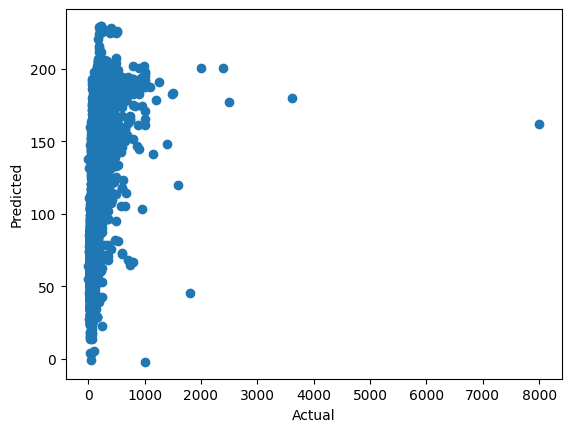

In [116]:
# plot actual vs predicted
plt.scatter(y_test, y_pred_linreg)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [117]:
from sklearn.metrics import mean_squared_error

mse_linreg = mean_squared_error(y_test, y_pred_linreg)
rmse_linreg = np.sqrt(mse_linreg)
mse_linreg, rmse_linreg

(21349.15965662691, 146.11351633790392)

In [118]:
# decision tree
from sklearn.tree import DecisionTreeRegressor as DTR

tree = DTR(random_state=1)
tree.fit(X_train, y_train)

y_pred_tree = tree.predict(X_test)
results_tree = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_tree})
results_tree.head(10)

,Actual,Predicted
29475,60,45.0
12661,95,45.0
5865,195,150.0
8623,91,155.0
14847,70,87.0
23148,229,102.0
7450,190,189.0
41737,135,110.0
34391,175,60.0
39297,240,187.0


In [119]:
# mse and rmse for tree
mse_tree = mean_squared_error(y_test, y_pred_tree)
rmse_tree = np.sqrt(mse_tree)
mse_tree, rmse_tree

(21996.784270819924, 148.31312912490225)

In [120]:
feature_names = X.columns
feature_imp = pd.DataFrame({'importance':tree.feature_importances_}, index=feature_names)
feature_imp.sort_values(by='importance', ascending=False).head(10)

,importance
Entire home/apt,0.393501
longitude,0.103193
latitude,0.099014
availability_365,0.049737
days_since_last_review,0.038976
textfeat2,0.038971
reviews_per_month,0.034360
textfeat5,0.033982
number_of_reviews,0.031065
textfeat6,0.029306


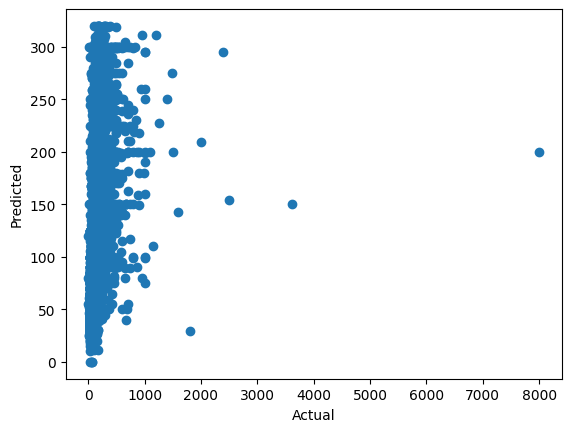

In [126]:
# plot actual vs predicted
plt.scatter(y_test, y_pred_tree)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [121]:
from sklearn.ensemble import RandomForestRegressor as RFR

bag = RFR(max_features=X_train.shape[1], random_state=1)
bag.fit(X_train, y_train)

RandomForestRegressor(max_features=22, random_state=1)

In [122]:
y_pred_bag = bag.predict(X_test)
results_bag = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_bag})
results_bag.head(10)

,Actual,Predicted
29475,60,106.05
12661,95,106.47
5865,195,195.19
8623,91,146.16
14847,70,86.15
23148,229,157.30
7450,190,151.28
41737,135,133.09
34391,175,160.46
39297,240,168.30


In [123]:
bag_mse = mean_squared_error(y_test, y_pred_bag)
bag_rmse = np.sqrt(bag_mse)
bag_mse, bag_rmse

(20124.013403192177, 141.8591322516537)

In [124]:
feature_names = X.columns
feature_imp = pd.DataFrame({'importance':bag.feature_importances_}, index=feature_names)
feature_imp.sort_values(by='importance', ascending=False).head(10)

,importance
Entire home/apt,0.393184
longitude,0.110542
latitude,0.094715
availability_365,0.048874
textfeat2,0.037484
days_since_last_review,0.036736
reviews_per_month,0.035725
textfeat5,0.035643
number_of_reviews,0.031919
textfeat3,0.027790


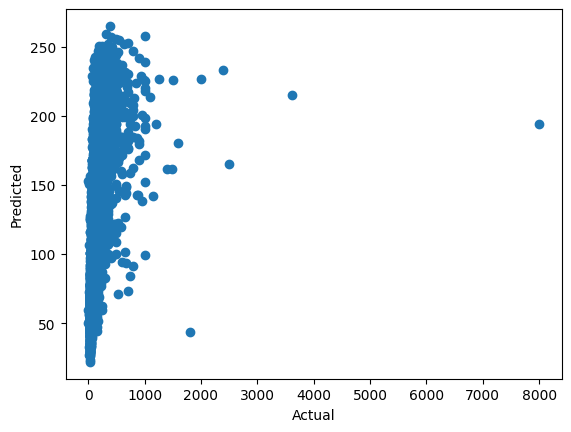

In [125]:
# plot actual vs predicted
plt.scatter(y_test, y_pred_bag)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()